In [2]:
#!pip install netCDF4==1.5.4
!pip3 list | grep numpy

numpy                             1.21.4                


In [1]:
import os
from netCDF4 import Dataset
from netCDF4 import num2date
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

## Descarga de archivo del Era5

In [ ]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-pressure-levels-monthly-means',
    {
        'format': 'netcdf',
        'product_type': 'monthly_averaged_reanalysis',
        'variable': [
            'divergence', 'relative_humidity', 'specific_humidity',
            'temperature', 'u_component_of_wind', 'v_component_of_wind',
            'vertical_velocity', 'vorticity',
        ],
        'pressure_level': [
            '200', '225', '250',
            '300', '350', '400',
            '450', '500', '550',
            '600', '650', '700',
        ],
        'year': '2021',
        'month': '10',
        'time': '00:00',
        'area': [
            30, -120, -60,
            -30,
        ],
    },
    'oct21.nc')

2022-01-02 19:51:38,884 INFO Welcome to the CDS
2022-01-02 19:51:38,886 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels-monthly-means
2022-01-02 19:51:39,253 INFO Request is queued
2022-01-02 19:51:40,728 INFO Request is running
2022-01-02 19:51:48,973 INFO Request is completed
2022-01-02 19:51:48,974 INFO Downloading https://download-0001.copernicus-climate.eu/cache-compute-0001/cache/data4/adaptor.mars.internal-1641171105.4399137-27171-5-46108cfd-6fd2-47c1-a5ca-12a7ac3da283.nc to oct21.nc (23.9M)
2022-01-02 19:52:27,127 INFO Download rate 640.6K/s 


Result(content_length=25027896,content_type=application/x-netcdf,location=https://download-0001.copernicus-climate.eu/cache-compute-0001/cache/data4/adaptor.mars.internal-1641171105.4399137-27171-5-46108cfd-6fd2-47c1-a5ca-12a7ac3da283.nc)

## Lectura de archivo

In [2]:
file = "NC/dic21.nc"
data = Dataset(file)

In [23]:
for v in data.variables.keys():
    print('%-15s'%v,data.variables[v].long_name)

longitude       longitude
latitude        latitude
level           pressure_level
time            time
d               Divergence
r               Relative humidity
q               Specific humidity
t               Temperature
u               U component of wind
v               V component of wind
w               Vertical velocity
vo              Vorticity (relative)


## Función Cmap

In [3]:
def c_cmap(file,sheet,clevs,inv=False):
    import pandas as pd
    from matplotlib.colors import ListedColormap, BoundaryNorm
    
    df = pd.read_excel(file,sheet) # lee el archivo excel y divide los valores entre 255
    df = df[['R','G','B']]/255
    if inv:
        df=df.iloc[::-1]   # Si es especificado invierte la barra de colores    
    cc=df.values.tolist()
    cmap = ListedColormap(cc[1:-1])
    cmap.set_under(cc[0])
    cmap.set_over(cc[-1])
    norm = BoundaryNorm(clevs,cmap.N)
    return cmap,norm

In [4]:
lt = data.variables['latitude'][:]
ln = data.variables['longitude'][:]
ln,lt = np.meshgrid(ln,lt)
times=data.variables['time']
vtimes = num2date(times[:], times.units)
levels = data['level'][:].tolist()

In [8]:
month = vtimes[0].strftime("%b")
folder='Img/{}'.format(month)
os.makedirs(folder) if not os.path.exists(folder) else 'No'

'No'

## Sudamérica

### Líneas de corriente

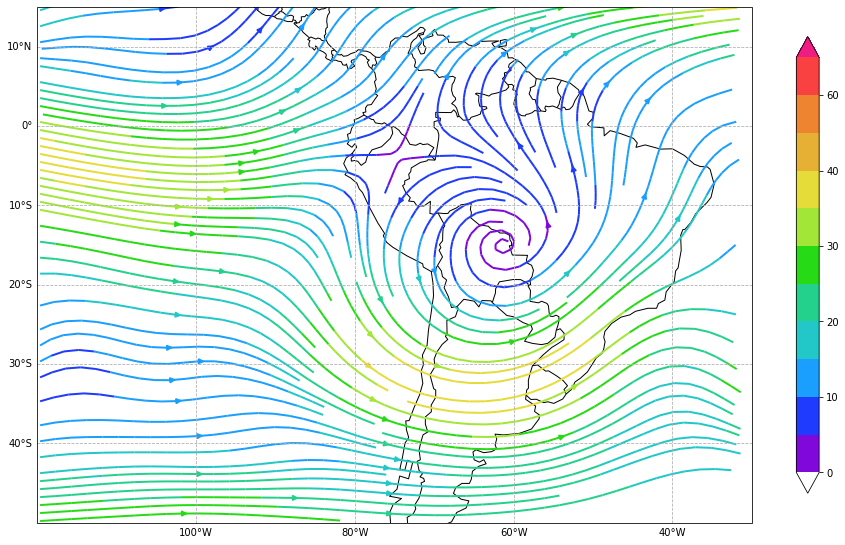

In [21]:
niv = levels.index(200) #Modificar nivel

u  = data.variables['u'][0,niv,:,:]
v  = data.variables['v'][0,niv,:,:]

levs = [0,5,10,15,20,25,30,35,40,50,60,65]
cmap, norm = c_cmap('Colores/lcorr.xlsx', '200', levs)

prj = ccrs.PlateCarree()
fig = plt.figure(figsize=(16,10.5), facecolor='white')
ax = plt.axes(projection = prj)

#Con color cambiante de acuerdo a la velocidad
sp = np.sqrt(u**2 + v**2)
lw = 5*sp / sp.max()
strm = ax.streamplot(ln, lt, u, v, color = sp, cmap=cmap,norm = norm, linewidth=2, density=6)
fig.colorbar(strm.lines, shrink = 0.8, extend='both')

ax.add_feature(cfeature.BORDERS,edgecolor='k')
ax.add_feature(cfeature.COASTLINE,edgecolor='k')
gl = ax.gridlines(draw_labels=True,linestyle='--')
gl.top_labels = gl.right_labels = False
ax.set_extent([-120,-30,-50,15], crs=prj)

fig.savefig('Img/{}/lcorr200.png'.format(month), dpi=fig.dpi, bbox_inches= 'tight')

plt.show()

## Perú

In [10]:
lt = data.variables['latitude'][:]
ln = data.variables['longitude'][:]
ln,lt = np.meshgrid(ln,lt)
times=data.variables['time']
vtimes = num2date(times[:], times.units)
levels = data['level'][:].tolist()

### Divergencia

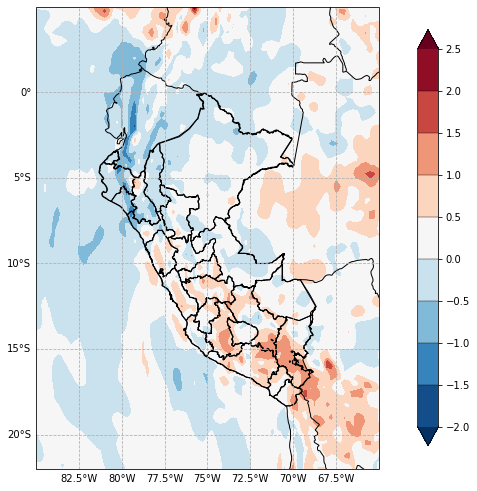

In [11]:
div = data['d'][0,levels.index(250),:,:]*1e05
levs=np.arange(-2,3,0.5)

#Creacion de colores
fig=plt.figure(figsize=(14,8.5),facecolor='white')
prj=ccrs.PlateCarree()
ax = plt.axes(projection=prj)

dir_shp = 'SHP/DEPARTAMENTOS.shp'
shp = list(shpreader.Reader(dir_shp).geometries())

cx = ax.contourf(ln,lt,div,levs,transform=prj,cmap = 'RdBu_r', extend='both')
cc=plt.colorbar(cx,shrink=0.9,drawedges=True)

ax.add_geometries(shp,prj,edgecolor='black',facecolor='None')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
#=============================================================================
gl = ax.gridlines(draw_labels=True,linestyle='--')
gl.top_labels = gl.right_labels = False
ax.set_extent([-85,-65,-22,5], crs=prj)

#plt.colorbar(cx)

fig.savefig('Img/{}/div250.png'.format(month), dpi=fig.dpi, bbox_inches= 'tight')

plt.show()

### Humedad

#### Humedad relativa promedio

In [12]:
#Cálculo de HR promedio
r_sum = 0
u_sum = 0
v_sum = 0
for i in range(levels.index(600)+1):
    r = data['r'][0,i,:,:]
    u = data['u'][0,i,:,:]
    v = data['v'][0,i,:,:]
    r_sum = r_sum + r
    u_sum = u_sum + u
    v_sum = v_sum + v
hrp = (r_sum/len(levels[:levels.index(600)]))
up = (u_sum/len(levels[:levels.index(600)]))
vp = (v_sum/len(levels[:levels.index(600)]))

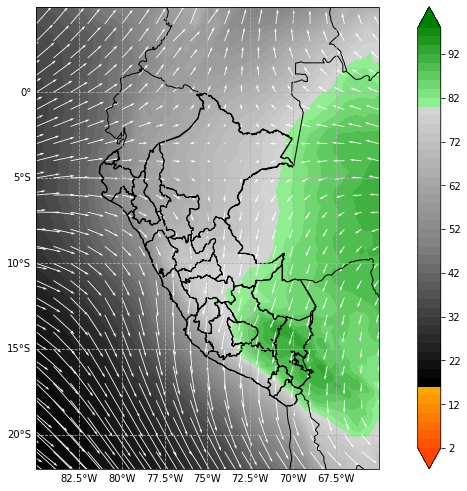

In [13]:
levs = np.arange(2,100,2)
cmap, norm = c_cmap('Colores/hrp.xlsx', 'hrp', levs)

fig=plt.figure(figsize=(14,8.5), facecolor='white')
prj=ccrs.PlateCarree()
ax = plt.axes(projection = prj)
cx = ax.contourf(ln,lt,hrp,levs, transform=prj, cmap=cmap, norm = norm, extend='both')
ax.quiver(ln[::4,::4],lt[::4,::4],up[::4,::4],vp[::4,::4], color = 'w', scale = 80)

#Límites de países y departamentos
dir_shp = 'SHP/DEPARTAMENTOS.shp'
shp = list(shpreader.Reader(dir_shp).geometries())
ax.add_geometries(shp,prj,edgecolor='black',facecolor='None')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
#Grillas y etiquetas de lat,lon
gl = ax.gridlines(draw_labels=True,linestyle='--')
gl.top_labels = gl.right_labels = False
ax.set_extent([-85,-65,-22,5], crs=prj)

plt.colorbar(cx)

fig.savefig('Img/{}/hrp.png'.format(month), dpi=fig.dpi, bbox_inches= 'tight')

plt.show()

#### Humedad específica

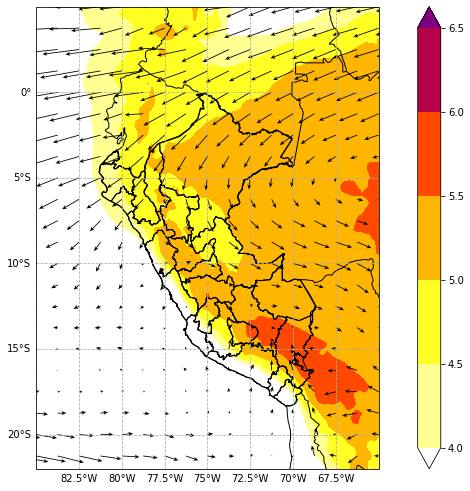

In [14]:
niv = levels.index(550) #Modificar nivel
q = data['q'][0,niv,:,:]*1000
u  = data.variables['u'][0,niv,:,:]
v  = data.variables['v'][0,niv,:,:]

levs = np.arange(4,7,0.5)
cmap, norm = c_cmap('Colores/rmix.xlsx', '550', levs)

fig=plt.figure(figsize=(14,8.5), facecolor='white')
prj=ccrs.PlateCarree()
ax = plt.axes(projection = prj)

sn = 5
cx = ax.contourf(ln,lt,q,levs, transform=prj, cmap=cmap, norm= norm, extend='both')
ax.quiver(ln[::sn,::sn],lt[::sn,::sn],u[::sn,::sn],v[::sn,::sn], color = 'k', scale = 50, headwidth=5, headlength=6)

#Límites de países y departamentos
dir_shp = 'SHP/DEPARTAMENTOS.shp'
shp = list(shpreader.Reader(dir_shp).geometries())
ax.add_geometries(shp,prj,edgecolor='black',facecolor='None')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
#Grillas y etiquetas de lat,lon
gl = ax.gridlines(draw_labels=True,linestyle='--')
gl.top_labels = gl.right_labels = False
ax.set_extent([-85,-65,-22,5], crs=prj)

plt.colorbar(cx)

fig.savefig('Img/{}/q550.png'.format(month), dpi=fig.dpi, bbox_inches= 'tight')

plt.show()

### Temperatura potencial equivalente

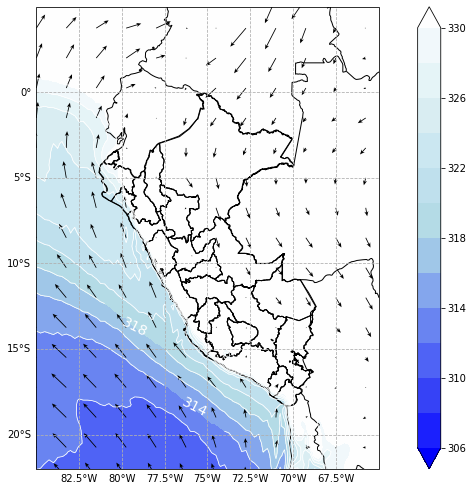

In [20]:
niv = levels.index(950) #Modificar nivel
t  = data.variables['t'][0,niv,:,:]
r = data['r'][0,niv,:,:]
u  = data.variables['u'][0,niv,:,:]
v  = data.variables['v'][0,niv,:,:]

es=6.11*pow(10,((7.5*(t-273))/(237.5+(t-273))))
e=es*r/100
rm=0.622*e/(950-e)
te=t*(1+(2529.8804*rm/t))
tpe=te*pow(1000/950,0.286)

levs = np.arange(306,332,2)
cmap, norm = c_cmap('Colores/tpe.xlsx', '950', levs)

fig=plt.figure(figsize=(14,8.5), facecolor='white')
prj=ccrs.PlateCarree()
ax = plt.axes(projection = prj)
sn = 7
cx = ax.contourf(ln,lt,tpe,levs, transform=prj, cmap=cmap, norm= norm, extend='both')
cs = ax.contour(ln,lt,tpe,levs,transform=prj, colors='w',linewidths=0.8)
ax.clabel(cs,colors='w',fmt='%d', inline=1, fontsize=14,inline_spacing=4)
ax.quiver(ln[::sn,::sn],lt[::sn,::sn],u[::sn,::sn],v[::sn,::sn], color = 'k', scale = 120, headwidth=5, headlength=6)

#Límites de países y departamentos
dir_shp = 'SHP/DEPARTAMENTOS.shp'
shp = list(shpreader.Reader(dir_shp).geometries())
ax.add_geometries(shp,prj,edgecolor='black',facecolor='None')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
#Grillas y etiquetas de lat,lon
gl = ax.gridlines(draw_labels=True,linestyle='--')
gl.top_labels = gl.right_labels = False
ax.set_extent([-85,-65,-22,5], crs=prj)

plt.colorbar(cx)

fig.savefig('Img/{}/tpe950.png'.format(month), dpi=fig.dpi, bbox_inches= 'tight')

plt.show()